# **Introduction**

We load in the data and arrange it properly.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

data = np.load('USPS_data.npy', allow_pickle = True).item()

In [ ]:
X_train = list(data.values())[0]
Y_test = list(data.values())[1]
X_test = list(data.values())[2]
Y_train = list(data.values())[3]

# **Exercise 16**

**b)**

In [ ]:
def FitStump(X,Y,w,gamma):
    ''' 
    function to compute the optimal (generalized) decision stump given the 
    input parameters

    X (nxd), Y (nx1): training data
    w (dx1): fixed weight vector
    gamma (nx1): weights

    a,b,c: parameters of optimal decision stump
    minError: minimal error of optimal decision stump
    '''
    n = X.shape[0]

    # determine the n+1 different thresholds
    bs = np.sort((X@w)*(-1))
    bs = np.append(bs, (bs[len(bs)-1]+0.001))

    mat = np.array([X@w]*len(bs)).T+np.array([bs]*(len(bs)-1))>0

    mat_a = 1+np.mean(mat, axis = 0)
    mat_a[mat_a == 0] = 10e-10

    a = 1 / mat_a
    c = np.mean(np.array([Y] * len(bs)).T.squeeze() - a*mat, axis = 0)

    LSerror = gamma.T@(np.array([Y] * len(bs)).T.squeeze()-(a*mat+np.array([c]*X.shape[0])))**2

    minError = np.min(LSerror) 

    a = a[np.argmin(LSerror)]
    b = bs[np.argmin(LSerror)]
    c = c[np.argmin(LSerror)]

    return a,b,c,minError

**c)**

In [ ]:
def GentleBoost(X,Y,k):
    ''' 
    function to perform GentleBoost for k iterations using the weak learner
    defined in FitStump(); the weights are drawn uniformly from the unit sphere
    and all paramters of the stump are saved in respective matrices and 
    subsequently returned

    X, Y: training data
    k: maximum number of iterations (number of used weak learners)

    final_loss: average loss across all folds
    '''
    n = X.shape[0]
    d = X.shape[1]

    aparam = np.zeros([k, 1])
    bparam = np.zeros([k, 1])
    cparam = np.zeros([k, 1])
    W = np.zeros([d, k])

    # uniformly initialize weights
    gamma = np.full((n, 1), 1/n)

    for i in tqdm(range(k)): # k iterations
      w = np.random.randn(d)
      w = w/np.linalg.norm(w)

      aparam[i], bparam[i], cparam[i], minError = FitStump(X,Y,w,gamma)
      W[:,i] = w
      pred = (aparam[i]*(X@w+bparam[i]>0)+cparam[i]).reshape(X.shape[0], 1)

      gamma = gamma*np.exp(-Y*pred)
      gamma = gamma/np.sum(gamma)

    return W, aparam, bparam, cparam


def predict_Gentleboost(X, W, a, b, c):
  """ 
  function to compute the prediction of the GentleBoost algorithms given the 
  parameter matrices of the individual iterations
  """

  pred_weak_learners = np.array([a]*X.shape[0]).squeeze()*((X@W)+np.array([b]*X.shape[0]).squeeze()>0)+np.array([c]*X.shape[0]).squeeze()
  pred_comb = np.cumsum(pred_weak_learners, axis = 1)

  return np.sign(pred_comb) 

**d)**

For excercise 16 d), we shall only consider those labels with a value of 0 or 1. Hence, we remove all others (including features with a correponding label which is not 0 or 1). Also, we change the value of 0 to -1. Like this, we can take the sign of the sum of weak learners as the final output (as in shown in the lecture slides).

The shapes of the new test and training set are displayed below.

In [ ]:
# construct dataset for task at hand

ind_train_01 = np.where((Y_train == 0) | (Y_train == 1))[0]
ind_test_01 = np.where((Y_test == 0) | (Y_test == 1))[0]

X_train_01 = X_train[ind_train_01]
Y_train_01 = Y_train[ind_train_01]
Y_train_01 = np.where(Y_train_01==0, -1, Y_train_01) # transform into Y={-1,1}

X_test_01 = X_test[ind_test_01]
Y_test_01 = Y_test[ind_test_01]
Y_test_01 = np.where(Y_test_01==0, -1, Y_test_01) 

print(X_train_01.shape)
print(X_test_01.shape)

(712, 256)
(623, 256)


We now apply the GentleBoost 1000 times.

In [ ]:
np.random.seed(42)

W, a, b, c = GentleBoost(X_train_01, Y_train_01, 1000)

100%|██████████| 1000/1000 [00:21<00:00, 46.00it/s]


Finally, we plot the training and test error.

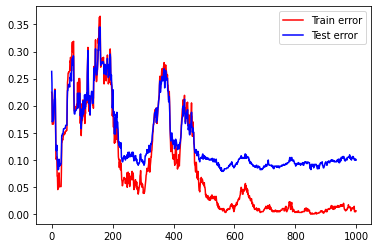

In [ ]:
# compute & plot training and test error as function of number of iterations

train_preds = predict_Gentleboost(X_train_01, W, a, b, c)
test_preds = predict_Gentleboost(X_test_01, W, a, b, c)

train_pred_mat = np.array([Y_train_01]*1000).T.squeeze() + train_preds
train_error = (np.count_nonzero(train_pred_mat == 0, axis = 0) / train_pred_mat.shape[0])

test_pred_mat = np.array([Y_test_01]*1000).T.squeeze() + test_preds
test_error = (np.count_nonzero(test_pred_mat == 0, axis = 0) / test_pred_mat.shape[0])

x = range(1000)
plt.plot(x, train_error, label = "Train error", c = 'red')
plt.plot(x, test_error, label = "Test error", c = 'blue')
plt.legend(loc="upper right")
plt.show()

**How is the curve of the test error compared to those of other methods analyzed?**

The plot displays that both the train and test error go hand in hand for few weak learners where the overall magnitude of the error is fluctuating. In this case (rather small k), the overall classifier avergaes of rather few rather poorly performing classifiers to this is no surprise. 

As k > 450 (roughly), the train error decreases significantly. The test error also decreases further, i.e. overfitting does not seem to be an issue here. This is in sharp constrast to other learning methods we have considered before. The latter might be traced back to the fact that each decision stump has low complexity and will thus not overfit. Even when considering multiple stumps in boosting, one only averages over these non-complex functions so that overfitting does not set in. 